# Lab 1

Matthew Rossouw
- z5220299
- 2022T2

In [235]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import cv2

cat = cv2.imread("Cat.png")
ct = cv2.imread("CT.png")
dog = cv2.imread("Dog.png")
kitten = cv2.imread("Kitten.png")

def mplib_show(img):
    """
    Shows an image using matplotlib because cv2 crashes in WSL.
    """
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')

### 1. Contrast stretching



In [236]:
def contrast_stretch(img: np.ndarray, a: int, b: int) -> np.ndarray:
    """
    Contrast stretches an image between intensity a -> b.
    Checks the blue value of colour tuples, since greyscale is assumed.
    
    Args:
        img: a greyscale image.
        a: minimum contrast value.
        b: maximum contrast value.
    Returns:
        np.ndarray: output image
    """
    if a >= b:
        raise Exception("Minimum bound must be less than maximum bound")
    
    # get min/max intensity
    (c, d) = find_minmax_intensity(img)

    # get size of image
    (iy, ix, ic) = img.shape

    # apply contrast stretch to each pixel
    for y in range(0, iy):
        for x in range(0, ix): # range loops are used here because iterators are read-only.
            # perform transform
            i : int = (img[y][x][0] - c) * (abs(b-a)/abs(d-c)) + a
            
            # Enforce limit between 0-255
            # i = max(i, 0)
            # i = min(i, 255)
            
            # set pixel
            img[y][x] = (i, i, i)

    return img

def find_minmax_intensity(img: np.ndarray):
    """
    Find maximum and minimum intensity of a greyscale image.
    Samples blue value since greyscale is assumed.

    Args:
        img: a greyscale image
    Returns:
        (min, max): tuple of integers for minimum and maximum.
    """
    min = 255   # minimum intensity value
    max = 0     # maximum intensity value

    # iterate over image and find minimum and maximum values
    for row in img:
        for px in row:
            if px[0] < min:
                min = px[0]
            if px[0] > max:
                max = px[0]
    
    return (min, max)

Before transform => min: 26 max: 150
After transform => min: 0 max: 255


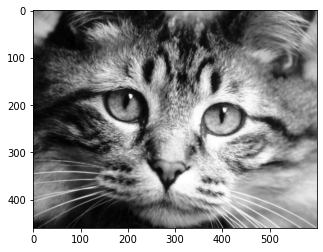

In [237]:
# Test of contrast_stretch
kitten = cv2.imread("Kitten.png")
(r_min, r_max) = find_minmax_intensity(kitten)

kitten_cs = contrast_stretch(kitten, 0, 255)
(cs_min, cs_max) = find_minmax_intensity(kitten_cs)

print(f"Before transform => min: {r_min} max: {r_max}")
print(f"After transform => min: {cs_min} max: {cs_max}")

mplib_show(kitten_cs)


### 2. Intensity histogram

In [238]:
def histogram(img: np.ndarray) -> None:
    """
    Renders a histogram using Matplotlib.pyplot from a greyscale image.
    Assumes 8 bit colour depth.
    Args:
        img: a grayscale image
    """
    # Get image params
    (iy, ix, c) = img.shape

    # Create array of intensity values
    i = [0] * 256
    flattened = img.ravel()

    # Iterate over image and calculate values
    for px in flattened:
        i[px] += 1
    
    # Create chart.
    plt.bar(range(0,256), i)
    plt.xlabel("Grey value")
    plt.ylabel("Occurences")
    plt.title("Histogram")
    # plt.semilogy() # log scale occurences
    plt.show()


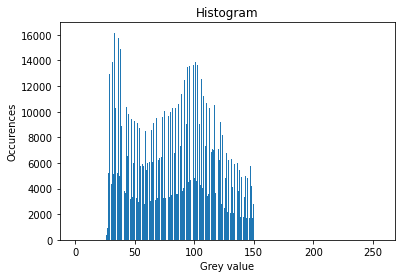

In [239]:
# Test histogram, plain image
kitten = cv2.imread("Kitten.png")
histogram(kitten)

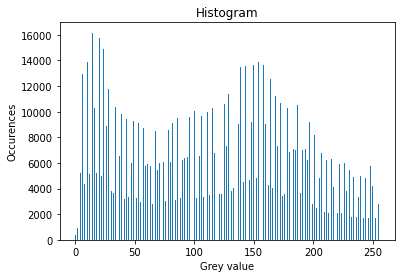

In [240]:
# Test histogram, contrast stretched image
kitten = cv2.imread("Kitten.png")
kitten = contrast_stretch(kitten, 0, 255)
histogram(kitten)

### 3. Image edges


In [265]:
sorbel_y = [[-1,-2,-1],[ 0, 0, 0],[ 1, 2, 1]]
sorbel_x = [[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]

def filter(img: np.ndarray, k) -> np.ndarray:
    """
    Apply a 3x3 kernel to an image.
    Args:
        img: input image
        k: convolution kernel
    """
    (s_y, s_x, s_c) = img.shape
    out = img.copy()
    for y in range(0,s_y):
        for x in range(0,s_x):
            out[y][x] = (0,0,0)
            px:np.uint8 = 0
            # Apply convolution
            for yy in range(-1, 2):
                for xx in range(-1, 2):
                    # Apply clamp padding.
                    xxx:np.uint8 = min(s_x - 1, max(0, x + xx))
                    yyy:np.uint8 = min(s_y - 1, max(0, y + yy))
                    
                    px += img[yyy][xxx][0] * k[xx+1][yy+1]
            # normalise -> maximum out from convolution is +-2040
            px += 2040
            px /= 4080
            px *= 255
            
            # set pixel value
            out[y][x] = (px, px, px)

    return out

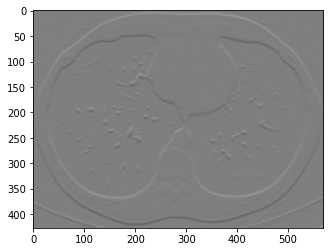

In [266]:
# Test sorbel x
ct_x = cv2.imread("CT.png")
ct_x = filter(ct_x, sorbel_x)
# ct_x = contrast_stretch(ct_x,0, 255)
mplib_show(ct_x)

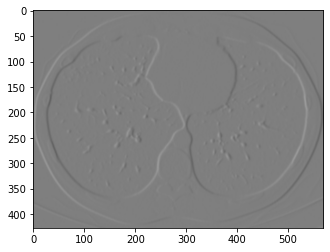

In [267]:
# Test sorbel y
ct_y = cv2.imread("CT.png")
ct_y = filter(ct_y, sorbel_y)

# ct_y = contrast_stretch(ct_y,0, 255)
mplib_show(ct_y)

i am miserable because it took me a long time to realise that cv2 datatypes inside of the arrays in images are silently unsigned, despite what the vscode python tells me. silent conversions to C datatypes by the python kernel are not cool

In [300]:
import math
# Gradient magnitude
def sorbel(img: np.ndarray):
    """
    Calculates gradient magnitude sorbel image of a greyscale image
    Args:
        img: A greyscale image
    """
    
    # Calculate sorbel images, but leave them in signed format
    out_cv = img.copy()
    (s_y, s_x, s_c) = img.shape
    out_x = np.zeros((s_y, s_x), int)
    out_y = np.zeros((s_y, s_x), int)

    for y in range(0,s_y - 1):
        for x in range(0,s_x - 1):
            px_x = 0
            px_y = 0
            # Apply convolution
            for yy in range(-1, 2):
                for xx in range(-1, 2):
                    # Apply clamp padding.
                    xxx = min(s_x - 1, max(0, x + xx))
                    yyy = min(s_y - 1, max(0, y + yy))
                    
                    px_x += img[yyy][xxx][0] * sorbel_x[xx+1][yy+1]
                    px_y += img[yyy][xxx][0] * sorbel_y[xx+1][yy+1]
            # # normalise -> maximum out from convolution is +-2040
            # px += 2040
            # px /= 4080
            # px *= 255
            
            # set pixel value
            out_x[y][x] = px_x
            out_y[y][x] = px_y
    
    # Combine sorbel images in gradient magnitude form
    for y in range(0, s_y):
        for x in range (0, s_x):
            px:np.uint8 = math.isqrt(out_x[y][x]**2 + out_y[y][x]**2)
            # normalise -> maximum out is ~361
            px /= 361  
            px *= 255
            px ** 2

            # this could be normalised better by processing the separate sorbel images,
            # but i am tired. i square the image to maximise contrast in higher valued
            # pixels.

            out_cv[y][x] = (px, px, px)
    return out_cv
    

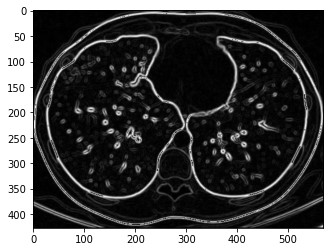

In [299]:
# test gradient magnitude
ct = cv2.imread("CT.png")
gm = sorbel(ct)
gm = contrast_stretch(gm, 0, 255)
mplib_show(gm)

### 4. Composition


In [315]:
filter_kernel = [[1,1,1,1,1],[1,2,3,2,1],[1,3,4,3,1],[1,2,3,2,1],[1,1,1,1,1]] 
def compose(img1: np.ndarray, img2: np.ndarray) -> None:
    """
    Applies a series of operations on two images.
    1. Edge detection on img1
    2. Uniform filtering on img2 using 5x5 kernel
    3. 50/50 composite of img1 and img2 with above operations applied.

    Args:
        img1: an image. Intended to be Cat.png.
        img2: an image. Intended to be Dog.png.
    """
    assert(img1.shape == img2.shape)

    # 1. edge detection:
    img1 = cv2.imread("Cat.png")
    img1 = sorbel(img1)

    # 2. uniform filtering
    img2 = cv2.imread("Dog.png")
    (s_y, s_x, s_c) = img2.shape
    out2 = img2.copy()
    for y in range(0,s_y):
        for x in range(0,s_x):
            out2[y][x] = (0,0,0)
            px:np.uint8 = 0
            # Apply convolution
            for yy in range(-2, 3):
                for xx in range(-2, 3):
                    # Apply clamp padding.
                    xxx:np.uint8 = min(s_x - 1, max(0, x + xx))
                    yyy:np.uint8 = min(s_y - 1, max(0, y + yy))
                    
                    # Sample all colour channels.
                    r = (img2[yyy][xxx][0] + img2[yyy][xxx][1] + img2[yyy][xxx][2])/3
                    px += r * (filter_kernel[xx+1][yy+1]/40)
                              
            # set pixel value
            out2[y][x] = (px, px, px)
    
    out = img1.copy()
    # 3. composite
    for y in range(0,s_y):
        for x in range(0,s_x):
            for i in range(3):
                out[y][x][i] = img1[y][x][i]*0.5 + img2[y][x][i]*0.5
    
    mplib_show(out)

/tmp/ipykernel_15228/3446407153.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
  r = (img2[yyy][xxx][0] + img2[yyy][xxx][1] + img2[yyy][xxx][2])/3


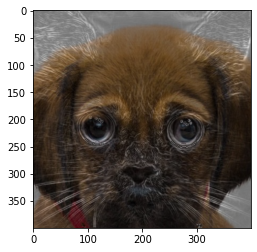

In [316]:
# test q3
cat = cv2.imread("Cat.png")
dog = cv2.imread("Dog.png")
compose(cat, dog)